In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from Olympic_PED_use.src import functions as fn

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV


In [32]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    sns.heatmap(cm,  cmap= 'Greens', annot=True, fmt='d')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [4]:
df = pd.read_csv('df.csv')

In [5]:
X = df.drop('flagged', axis=1)
y = df.flagged
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.21)

In [6]:
cont_features = ['age', 'height', 'weight', 'results']
cat_features = ['sex', 'team', 'noc', 'season', 'city', 'sport',
                       'event_x', 'medal']

In [7]:
X_train_cont = X_train[cont_features].astype(float)
X_train_cat = X_train[cat_features]
X_test_cont = X_test[cont_features].astype(float)
X_test_cat = X_test[cat_features]

X_train_index = X_train.index
X_test_index = X_test.index

ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_cont), 
                              columns=X_train[cont_features].columns, 
                              index=X_train_index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_cont), 
                             columns=X_test[cont_features].columns, 
                             index=X_test_index)
ohe = OneHotEncoder()
X_train_encoded = ohe.fit_transform(X_train_cat)
X_test_encoded = ohe.transform(X_test_cat)

train_columns = ohe.get_feature_names(input_features=X_train_cat.columns)
test_columns = ohe.get_feature_names(input_features=X_test_cat.columns)

X_train_processed = pd.DataFrame(X_train_encoded.todense(), columns=train_columns, index=X_train_index)
X_test_processed = pd.DataFrame(X_test_encoded.todense(), columns=test_columns, index=X_test_index)

In [8]:
X_train_all = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_all = pd.concat([X_test_scaled, X_test_processed], axis=1)

0.0
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1079
         1.0       0.06      0.05      0.05        22

    accuracy                           0.97      1101
   macro avg       0.52      0.51      0.52      1101
weighted avg       0.96      0.97      0.96      1101

Recall:  0.045454545454545456
Accuracy:  0.9654859218891917
Precision:  0.05555555555555555


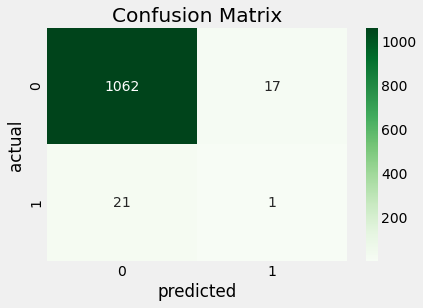

In [33]:
fsm = DummyClassifier(random_state=42)
fsm.fit(X_train_all, y_train)
print(np.mean(cross_val_score(fsm, X_test_all, y_test, scoring='recall',
                             cv=20, n_jobs=-1)))
evaluation(y_test, fsm.predict(X_test_all))

In [16]:
fsm_preds = fsm.predict(X_test_all)
fpr, tpr, thresholds = roc_curve(y_test, fsm_preds)
rocauc = auc(fpr, tpr)

In [24]:
rocauc

0.5148496082231021

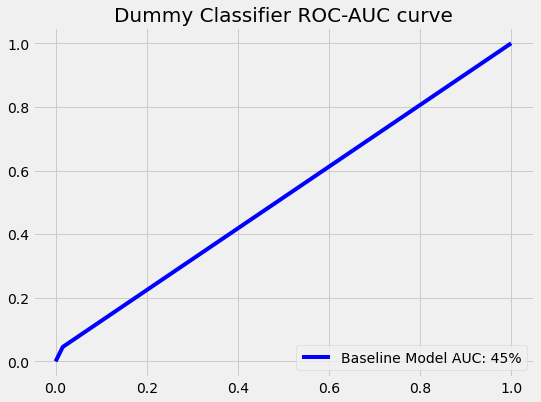

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))    
plt.plot(fpr, tpr, c='b', label='Baseline Model AUC: 45%')
plt.title('Dummy Classifier ROC-AUC curve', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('fsm_auc.png', bbox_inches='tight', transparent=True)

In [34]:
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN


In [35]:
train = df.drop('flagged', axis=1)

In [36]:
train_ohe = train[cat_features]
train_cont = train[cont_features]
train_index = train.index

ohe2 = OneHotEncoder()
ss2 = StandardScaler()

train_encoded = ohe2.fit_transform(train_ohe)
train_scaled = pd.DataFrame(ss2.fit_transform(train_cont), columns=train[cont_features].columns, index=train_index)

train_columns = ohe2.get_feature_names(input_features=train_ohe.columns)
train_processed = pd.DataFrame(train_encoded.todense(), columns = train_columns, index=train_index)

train_all = pd.concat([train_scaled, train_processed], axis=1)

In [37]:
train_all['flagged'] = df['flagged']

In [45]:
X_smote = train_all.drop('flagged', axis=1)
y_smote = train_all.flagged

smote = SMOTE(random_state=42)

x_res, y_res = smote.fit_sample(X_smote, y_smote)

In [46]:
X_t, X_val, y_t, y_val = train_test_split(x_res, y_res, random_state=42, test_size=.2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


0.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1041
         1.0       1.00      1.00      1.00      1022

    accuracy                           1.00      2063
   macro avg       1.00      1.00      1.00      2063
weighted avg       1.00      1.00      1.00      2063

Recall:  0.9990215264187867
Accuracy:  0.9995152690256908
Precision:  1.0


[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.1s finished


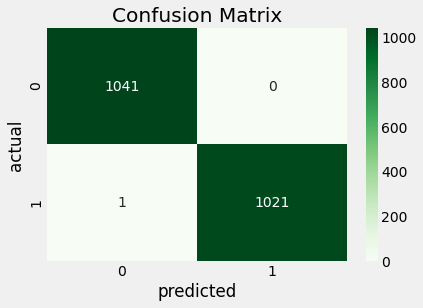

In [57]:
rf2 = RandomForestClassifier(max_depth=40, min_samples_split=4, 
                             n_estimators=500, n_jobs=-1, 
                             verbose=1, random_state=42)
rf2.fit(X_t, y_t)

print(np.mean(cross_val_score(rf2, X_test_all, y_test, scoring='recall',
                       n_jobs= -1, verbose=1, cv=20)))

evaluation(y_val, rf2.predict(X_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1079
         1.0       1.00      0.27      0.43        22

    accuracy                           0.99      1101
   macro avg       0.99      0.64      0.71      1101
weighted avg       0.99      0.99      0.98      1101

Recall:  0.2727272727272727
Accuracy:  0.9854677565849228
Precision:  1.0


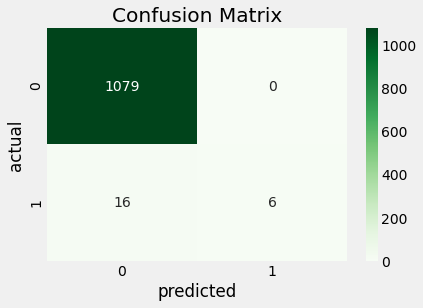

In [48]:
rf2.fit(X_train_all, y_train)
preds = rf2.predict(X_test_all)
evaluation(y_test, preds)

In [51]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf2.predict(X_test_all))
rf_rocauc = auc(rf_tpr, rf_fpr)
rf_rocauc

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.1s finished


0.36363636363636365

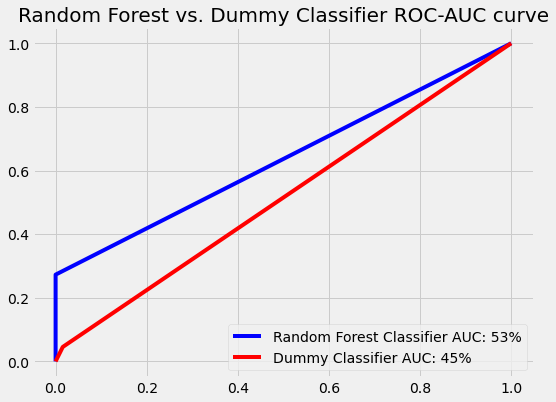

In [56]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))    
plt.plot(rf_fpr, rf_tpr, c='b', label='Random Forest Classifier AUC: 53%')
plt.plot(fpr, tpr, c='r', label='Dummy Classifier AUC: 45%')
plt.title('Random Forest vs. Dummy Classifier ROC-AUC curve', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('auc.png', bbox_inches='tight', transparent=True)